# High Level Pipline for GCN and GNODE for Brain State Identification

## Pipeline Overview

### 1.1 Adjacency Matrix Generation ---> **2.1 Unsupervised GCN** ---> 3.1 Supervised MLP

### 1.1 Adjacency Matrix Generation ---> **2.2 Unsupervised GNODE** ---> 3.1 Supervised MLP

[Introduction and overview should be written here]

#### High Level Classes imported:

DataManager.py DataManagerUtil.py : [insert description here]

GCN.py GCNutil.py : [insert description here]

GDE.py GDEutil.py GDEsolvers.py : [insert description here]

MLP.py : [insert description here]

In [112]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

#### Dataset:

[A short description here]

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------
print sample EGG signal from one node:


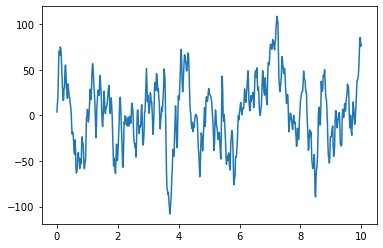

In [113]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_620.mat' #264 253 620
variables = load_patient_data(filepath, verbose = True)

In [114]:
#OPTIONAL: Shuffle the dataset
variables, indices = shuffle_train_test(variables, train_ratio = 0.5, print_summary = True)

X_train: (640, 31, 1456)
X_test: (640, 31, 1457)
y_train: (1, 1456) Positive labes: 155.0
y_test: (1, 1457) Positive labes: 166.0


In [115]:
#OPTIONAL: Remove Overlapping Parts
variables = remove_overlap(variables)

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 1.1 Adjacency Matrix Generation

[short description here]

##### 1.1.1 Create the datamanager object that computes the covariance matrix for you.

In [116]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


##### 1.1.2 Visualize the mean covariance matrix across all training samples

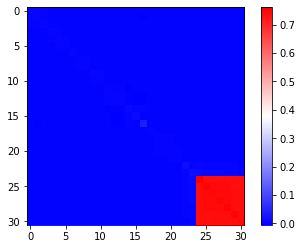

In [117]:
show_heat_map(dm.P_avg_train)

##### 1.1.3 Create DAD from dm by setting the threshold n. repeating this untill a desireble "n" value is found.

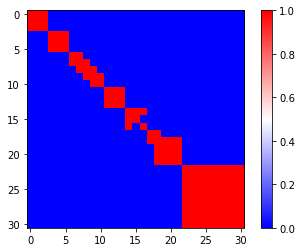

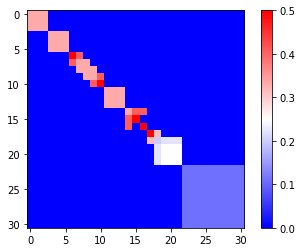

In [119]:
n = 1*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 2.1 Unsupervised Graph Convolutional Neural Network (GCN)

[short description here]

##### 2.1.1 Declare Parameters for GCN

In [120]:
#create new model
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(GCNparameters)
GCNcheckpoint = {'parameters': GCNparameters}

{'body': 257, 'M': 1431, 'batch_size': 128, 'n_layers': 2, 'num_epochs': 1, 'learning_rate': 0.001, 'weight_decay': 0.005}


##### 2.1.2 Train GCN

In [121]:
#strongly recommand cpu because it's only one epoch training time and CUDA some times run out of memory if you retrain multiple times
device_name = 'cpu'
GCNmodel, GCNcheckpoint = GCNutil.train_GCN(A, X_train, X_test, GCNcheckpoint, device_name = device_name, load = False, print_summary = False)

  8%|▊         | 1/12 [00:00<00:01,  7.90it/s]

device set to cpu


 25%|██▌       | 3/12 [00:00<00:01,  7.61it/s]

 42%|████▏     | 5/12 [00:00<00:00,  7.43it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  7.13it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  7.04it/s]

100%|██████████| 12/12 [00:01<00:00,  7.66it/s]

Epoch: 1   Batch: 12 of size 128   Train loss: 500.5848083496094   Valid loss: 500.003631591796925


In [122]:
#optional: saving the model
GCNutil.save_ckp(GCNcheckpoint, "models/GCN620_1.pt")

model saved


##### 2.1.3 Visualize some simularity matrices generated by GCN (a visual evaluation and sanity check)

In [123]:
GCNmodel.eval()
test_pred = GCNmodel(torch.from_numpy(X_train[:128, :,:]).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

sample 0   label, 0.0


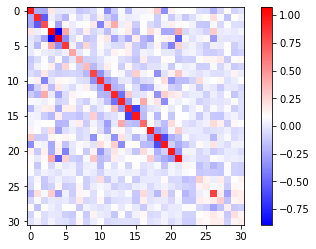

sample 1   label, 0.0


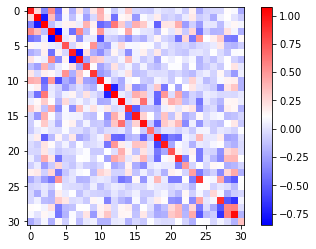

sample 2   label, 0.0


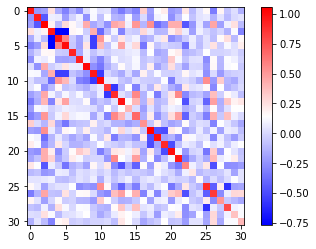

sample 3   label, 0.0


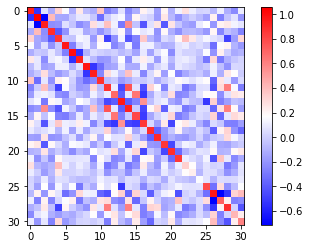

sample 4   label, 0.0


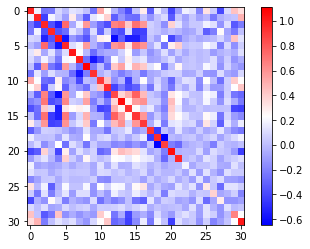

sample 5   label, 0.0


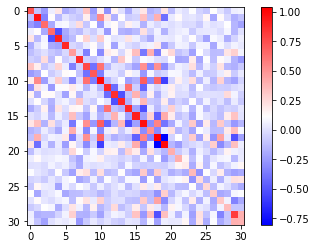

sample 6   label, 0.0


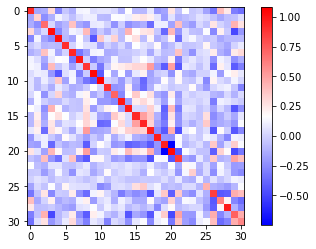

sample 7   label, 0.0


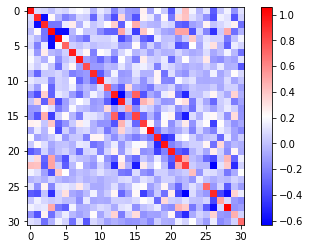

sample 8   label, 0.0


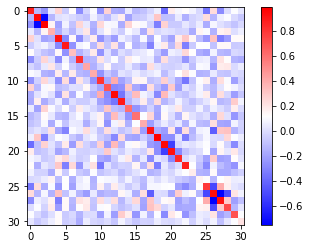

sample 9   label, 0.0


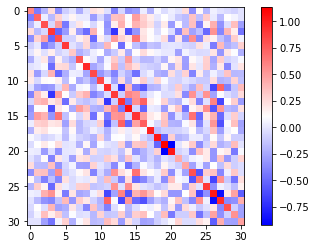

In [125]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 2.1 Unsupervised Graph Neural Ordinary Differential Equations (GNODE)

[short description here]

##### 2.2.1 Declare Parameters for GNODE

In [126]:
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.EF
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEcheckpoint = {'parameters': GDEparameters}

##### 2.2.2 Train GNODE

In [127]:
#strongly recommand cpu because it's only one epoch training time and CUDA some times run out of memory if you retrain multiple times
device_name = 'cpu'
GDEmodel, GDEcheckpoint = GDEutil.train_GDE(A, X_train, X_test, GDEcheckpoint, device_name = device_name, load = False, print_summary = False)

  0%|          | 0/12 [00:00<?, ?it/s]

device set to cpu


  8%|▊         | 1/12 [00:00<00:07,  1.55it/s]

 17%|█▋        | 2/12 [00:01<00:06,  1.52it/s]

 25%|██▌       | 3/12 [00:02<00:05,  1.51it/s]

 33%|███▎      | 4/12 [00:02<00:05,  1.50it/s]

 42%|████▏     | 5/12 [00:03<00:04,  1.48it/s]

 50%|█████     | 6/12 [00:04<00:04,  1.48it/s]

 58%|█████▊    | 7/12 [00:04<00:03,  1.49it/s]

 67%|██████▋   | 8/12 [00:05<00:02,  1.49it/s]

 75%|███████▌  | 9/12 [00:06<00:02,  1.50it/s]

 83%|████████▎ | 10/12 [00:06<00:01,  1.50it/s]

100%|██████████| 12/12 [00:07<00:00,  1.59it/s]

Epoch: 1   Batch: 12 of size 128   Train loss: 497.2356872558594   Valid loss: 496.73626708984375


In [128]:
#optional: saving the model
GDEutil.save_ckp(GDEcheckpoint, "models/GDE620_1.pt")

model saved


##### 2.2.3 Visualize some simularity matrices generated by GNODE (a visual evaluation and sanity check)

In [129]:
GDEmodel.eval()
test_pred = GDEmodel(torch.from_numpy(X_train[:128, :,:]).float().to(device_name)).cpu().detach().numpy()

sample 0   label, 0.0


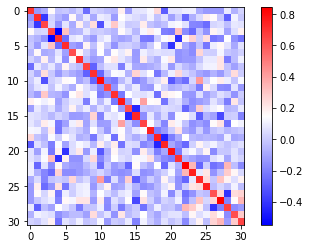

sample 1   label, 0.0


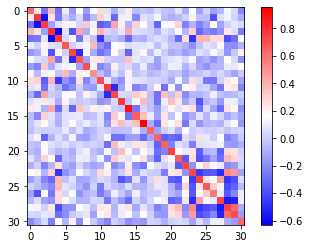

sample 2   label, 0.0


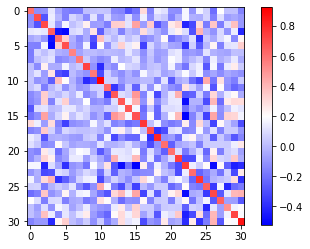

sample 3   label, 0.0


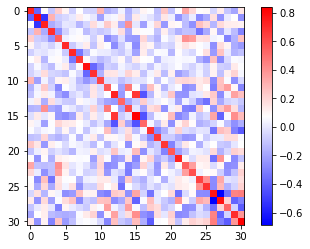

sample 4   label, 0.0


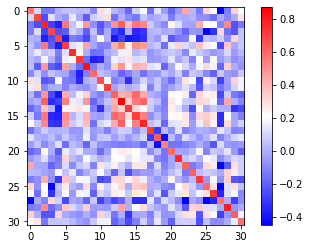

sample 5   label, 0.0


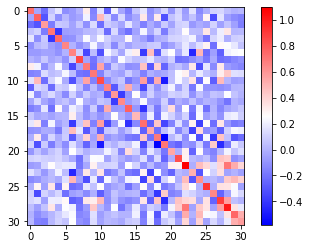

sample 6   label, 0.0


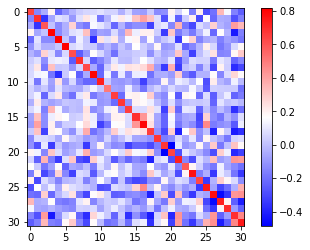

sample 7   label, 0.0


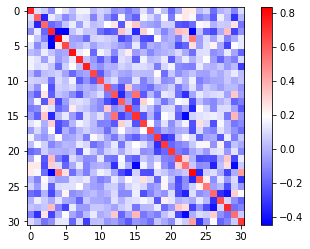

sample 8   label, 0.0


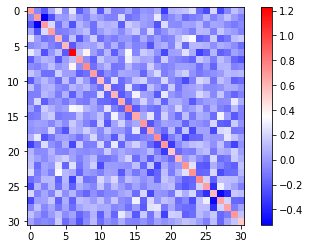

sample 9   label, 0.0


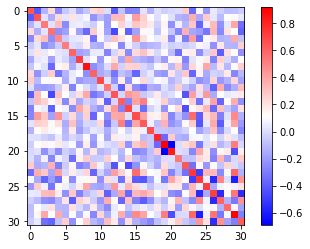

In [130]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 3.1 Supervised Multi-Layer Perceptron (MLP)

[short description here]

##### 3.1.1 Get simularity matrix from GCN and GNODE models

In [131]:
sim_all = {}
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
device_name = 'cpu'

In [132]:
#Get simularity matrix from GCN
GCNmodel.eval()
sim_all["GCN_train"] = GCNmodel(torch.from_numpy(X_train).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()
sim_all["GCN_test"] = GCNmodel(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

In [133]:
#Get simularity matrix from GNODE
GDEmodel.eval()
sim_all["GDE_train"] = GDEmodel(torch.from_numpy(X_train).float().to(device_name)).cpu().detach().numpy()
sim_all["GDE_test"] = GDEmodel(torch.from_numpy(X_test).float().to(device_name)).cpu().detach().numpy()

##### 3.1.2 Visualize the averaged ictal and non-ictal states for the two models

Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


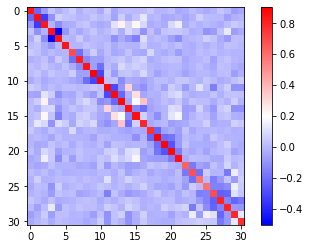

Average Non-Ictal


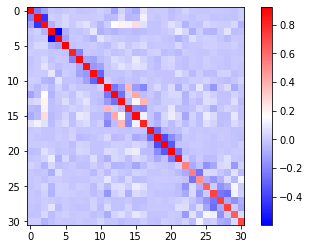

In [134]:
print("Average Ictal and Non-Ictal Simularity Matrix for GCN")
visualize_avg_sim_matrix(dm, sim_all["GCN_train"], sim_all["GCN_test"])

Average Ictal and Non-Ictal Simularity Matrix for GDE
Average ictal


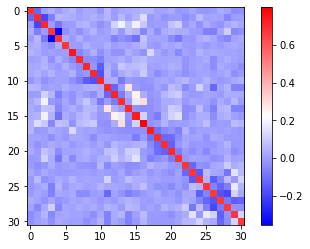

Average Non-Ictal


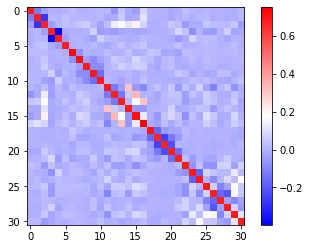

In [135]:
print("Average Ictal and Non-Ictal Simularity Matrix for GDE")
visualize_avg_sim_matrix(dm, sim_all["GDE_train"], sim_all["GDE_test"])

##### 3.1.3 MLP for GCN  

###### Training

In [156]:
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1, 1], 
    'dropout':[-1, -1],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGCN, _,_, MLPcheckpointGCN = MLP.train_MLP(dm, sim_all["GCN_train"], sim_all["GCN_test"], MLPparametersGCN, acc_fn=MLP.F1, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=496, out_features=496, bias=True)
    (1): ReLU()
    (2): Linear(in_features=496, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 496]         246,512
              ReLU-2                  [-1, 496]               0
            Linear-3                    [-1, 1]             497
           Sigmoid-4                    [-1, 1]               0
Total params: 247,009
Trainable params: 247,009
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.94
Estimated Total Size (MB): 0.95
----------------------------------------------------------------
Epoch: 1   Train loss: 0.4726   Train accuracy: 0.01   Val loss: 0.3287   Val accuracy: 0.278    weighted 

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


Epoch: 50   Train loss: 0.0833   Train accuracy: 0.837   Val loss: 0.2279   Val accuracy: 0.641    weighted Val loss: 0.3081
0.641 ----------saved-----------
Epoch: 51   Train loss: 0.0751   Train accuracy: 0.9   Val loss: 0.2256   Val accuracy: 0.639    weighted Val loss: 0.3077
Epoch: 52   Train loss: 0.0719   Train accuracy: 0.787   Val loss: 0.2344   Val accuracy: 0.609    weighted Val loss: 0.3073
Epoch: 53   Train loss: 0.0692   Train accuracy: 0.868   Val loss: 0.2275   Val accuracy: 0.624    weighted Val loss: 0.3069
Epoch: 54   Train loss: 0.0725   Train accuracy: 0.837   Val loss: 0.2294   Val accuracy: 0.62    weighted Val loss: 0.3065
Epoch: 55   Train loss: 0.0711   Train accuracy: 0.908   Val loss: 0.2383   Val accuracy: 0.613    weighted Val loss: 0.3062
Epoch: 56   Train loss: 0.0687   Train accuracy: 0.914   Val loss: 0.2394   Val accuracy: 0.623    weighted Val loss: 0.3058
Epoch: 57   Train loss: 0.0704   Train accuracy: 0.873   Val loss: 0.2339   Val accuracy: 0.617

In [158]:
#optional: save the model
MLP.save_ckp(MLPcheckpointGCN, "models/MLPGCN620_1.pt")

model saved


###### Result

In [162]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGCN, sim_all["GCN_test"], dm, threshold = t)

threshold: 0.05  validation loss: 0.2279 F1 accuracy 0.46 Precision accuracy 0.319 Recall accuracy 0.825 AUC accuracy: 0.882
threshold: 0.1  validation loss: 0.2279 F1 accuracy 0.543 Precision accuracy 0.426 Recall accuracy 0.75 AUC accuracy: 0.882
threshold: 0.15  validation loss: 0.2279 F1 accuracy 0.572 Precision accuracy 0.493 Recall accuracy 0.681 AUC accuracy: 0.882
threshold: 0.2  validation loss: 0.2279 F1 accuracy 0.602 Precision accuracy 0.556 Recall accuracy 0.656 AUC accuracy: 0.882
threshold: 0.25  validation loss: 0.2279 F1 accuracy 0.615 Precision accuracy 0.606 Recall accuracy 0.625 AUC accuracy: 0.882
threshold: 0.3  validation loss: 0.2279 F1 accuracy 0.625 Precision accuracy 0.653 Recall accuracy 0.6 AUC accuracy: 0.882
threshold: 0.35  validation loss: 0.2279 F1 accuracy 0.641 Precision accuracy 0.724 Recall accuracy 0.575 AUC accuracy: 0.882
threshold: 0.4  validation loss: 0.2279 F1 accuracy 0.633 Precision accuracy 0.736 Recall accuracy 0.556 AUC accuracy: 0.882


##### 3.1.2 MLP for GDE

###### Training

In [148]:
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 1], 
    'dropout':[0.5, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGDE, _,_, MLPcheckpointGDE = MLP.train_MLP(dm, sim_all["GDE_train"], sim_all["GDE_test"], MLPparametersGDE, acc_fn=MLP.F1, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=496, out_features=496, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=496, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 496]               0
            Linear-2                  [-1, 496]         246,512
              ReLU-3                  [-1, 496]               0
           Dropout-4                  [-1, 496]               0
            Linear-5                    [-1, 1]             497
           Sigmoid-6                    [-1, 1]               0
Total params: 247,009
Trainable params: 247,009
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.

In [149]:
#optional: save the model
MLP.save_ckp(MLPcheckpointGDE, "models/MLPGDE620_1.pt")

model saved


###### Result

In [163]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGDE, sim_all["GDE_test"], dm, threshold = t)

threshold: 0.05  validation loss: 0.228 F1 accuracy 0.482 Precision accuracy 0.35 Recall accuracy 0.775 AUC accuracy: 0.883
threshold: 0.1  validation loss: 0.228 F1 accuracy 0.593 Precision accuracy 0.545 Recall accuracy 0.65 AUC accuracy: 0.883
threshold: 0.15  validation loss: 0.228 F1 accuracy 0.633 Precision accuracy 0.694 Recall accuracy 0.581 AUC accuracy: 0.883
threshold: 0.2  validation loss: 0.228 F1 accuracy 0.608 Precision accuracy 0.735 Recall accuracy 0.519 AUC accuracy: 0.883
threshold: 0.25  validation loss: 0.228 F1 accuracy 0.585 Precision accuracy 0.796 Recall accuracy 0.463 AUC accuracy: 0.883
threshold: 0.3  validation loss: 0.228 F1 accuracy 0.58 Precision accuracy 0.835 Recall accuracy 0.444 AUC accuracy: 0.883
threshold: 0.35  validation loss: 0.228 F1 accuracy 0.576 Precision accuracy 0.895 Recall accuracy 0.425 AUC accuracy: 0.883
threshold: 0.4  validation loss: 0.228 F1 accuracy 0.537 Precision accuracy 0.91 Recall accuracy 0.381 AUC accuracy: 0.883
threshol